In [2]:
import pandas as pd
import numpy as np
import _pickle as pkl
from sklearn.model_selection import train_test_split
import re
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Test and Train

In [3]:
df = pd.read_csv('./datasets/train.csv')
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()

In [4]:
# from collections import Counter
# from string import punctuation

# soup = BeautifulSoup(X[70], 'html.parser')
# print(soup.prettify())

# # Title
# print("Title: ", soup.find("h1", {"class": "title"}).text)

# # Channel
# print("Data Channel: ", soup.find("article").get("data-channel"))

# # Author
# author_re = r'(By\s|^)(.*?)(?=\d{4}-\d{2}-\d{2}|$)'
# if soup.head.find("span") == None:
#     print("Author: None")
# else:
#     print("Author: ", re.search(author_re, soup.head.find("span").text).group(1))

# # Related Topics
# print("Topics: ", soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(","))

# # Time
# print("Time: ", re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5])

# # Weekend
# print("Weekend: ", int(soup.time.get("datetime")[:3] in ["Sat", "Sun"]))

# # Word Count
# text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
# c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
# text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
# c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
# total = c_div + c_p
# print("Total words: ", len(list(total.elements())))


# section = soup.find("section", {"class": "article-content"})

# # Video + Image count
# img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
# video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
# media_count = img_count + video_count
# print("Media count: ", media_count)

# # Appealing count
# link_count = len(section.find_all("a"))
# strong_count = len(section.find_all("strong"))
# appealing_count = link_count + strong_count
# print("Link count: ", appealing_count)


### Single Features Extractions 

In [5]:
def feature_selection_author(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    # Author formate may various from news website
    author = soup.find("span", {"class": "author_name"}) # default format
    if(author != None): 
        feature_str += author.text.replace("By ", "") + " "
    elif(soup.find("span") != None): 
        feature_str += soup.find("span").text + " "
    elif(soup.find("a") != None): 
        feature_str += soup.find("a").text + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_titles(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("h1", {"class": "title"}).text + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_channels(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("article").get("data-channel") + " "
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def feature_selection_topic(text):
    feature_str = ""
    soup = BeautifulSoup(text, 'html.parser')
    feature_str += soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").replace(",", "")
    feature_str = re.sub(r'[\W]+', ' ', feature_str.lower())
    return feature_str

def extract_weekend(text):
    soup = BeautifulSoup(text, 'html.parser')
    ret = 0
    if soup.time.text == None or soup.time.text == "":
        ret = 0
    else:
        if soup.time.get("datetime")[:3] in ["Sat", "Sun"]:
            ret = 1 
        else:
            ret = 0
    return ret

def extract_word_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    # Word Count
    text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
    c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
    text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
    c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
    total = c_div + c_p
    return len(list(total.elements()))

def extract_media_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    section = soup.find("section", {"class": "article-content"})
    img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
    video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
    media_count = img_count + video_count
    return media_count

def extract_appealing_count(text):
    soup = BeautifulSoup(text, 'html.parser')
    section = soup.find("section", {"class": "article-content"})
    link_count = len(section.find_all("a"))
    strong_count = len(section.find_all("strong"))
    appealing_count = link_count + strong_count
    return appealing_count



In [6]:
# nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

### Out of mem 

In [7]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk
batch_size = 1024
iters = int((27643+batch_size-1)/(batch_size*2))

In [8]:
stream = get_stream(path='./datasets/train.csv', size=batch_size)
idx = 0
X_train, y_train = None, None
batch_X, batch_y = None, None
for z in range(iters):
    batch = next(stream)
    if(idx==0):
        X_train= batch['Page content']
        y_train = batch['Popularity']
        idx+=1
    else:
        X_train = np.concatenate((X_train, batch['Page content']))
        y_train = np.concatenate((y_train, batch['Popularity']))
    batch = next(stream)

# Tfidf

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_author = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_author,
                        tokenizer=tokenizer_stem_nostop)

tfidf_channel = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_channels,
                        tokenizer=tokenizer_stem_nostop)

tfidf_title = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_titles,
                        tokenizer=tokenizer_stem_nostop)

tfidf_topic = TfidfVectorizer(ngram_range=(1,2),
                        preprocessor=feature_selection_topic,
                        tokenizer=tokenizer_stem_nostop)
tfidf_author.fit(X_train)
#tfidf_channel.fit(X_train)
tfidf_title.fit(X_train)
tfidf_topic.fit(X_train)

c:\Users\johnson\.conda\envs\DL2\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(ngram_range=(1, 2),
                preprocessor=<function feature_selection_topic at 0x000001FE6827DE40>,
                tokenizer=<function tokenizer_stem_nostop at 0x000001FE6827D8A0>)

# hash

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer

# hash words to 1024 buckets
hashvec_author = HashingVectorizer(n_features=2**10,
                            preprocessor=feature_selection_author,
                            tokenizer=tokenizer_stem_nostop)

hashvec_channel = HashingVectorizer(n_features=2**10,
                            preprocessor=feature_selection_channels,
                            tokenizer=tokenizer_stem_nostop)

hashvec_title = HashingVectorizer(n_features=2**10,
                            preprocessor=feature_selection_titles,
                            tokenizer=tokenizer_stem_nostop)

hashvec_topic = HashingVectorizer(n_features=2**10,
                            preprocessor=feature_selection_topic,
                            tokenizer=tokenizer_stem_nostop)

### Combine Feature Function


In [11]:
def combine(x_batch):
    x_batch_channel = ""
    x_batch_title = tfidf_title.transform(x_batch).toarray()
    #print(x_batch_title.shape)
    x_batch_author = tfidf_author.transform(x_batch).toarray()
    #print(x_batch_author.shape)
    x_batch_topic = tfidf_topic.transform(x_batch).toarray()
    #print(x_batch_topic.shape)
    # x_batch_channel = tfidf_channel.transform(x_batch).toarray()
    #print(x_batch_channel.shape)
    weekend_vectorized = np.vectorize(extract_weekend)
    x_batch_weekend = weekend_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_weekend.shape)
    media_vectorized = np.vectorize(extract_media_count)
    x_batch_media = media_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_media.shape)
    appealing_count_vectorized = np.vectorize(extract_appealing_count)
    x_batch_appealing = appealing_count_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_appealing.shape)
    word_vectorized = np.vectorize(extract_word_count)
    x_batch_word = word_vectorized(x_batch).reshape(len(x_batch),1)
    #print(x_batch_word.shape)
    # combined_x_batch = np.concatenate((x_batch_title, x_batch_author, x_batch_channel, x_batch_topic),axis=1)
    # , x_batch_weekend
    #                            , x_batch_media, x_batch_appealing, x_batch_word
    #print(combined_x_batch.shape)
    return x_batch_title, x_batch_author, x_batch_channel, x_batch_topic, x_batch_weekend, x_batch_media, x_batch_appealing, x_batch_word

In [12]:
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

## Hybrid

In [13]:
clf1 = RandomForestClassifier(n_estimators=50, max_depth=5)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=5)
clf3 = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)
clf4 = RandomForestClassifier(n_estimators=50, max_depth=5)
clf5 = RandomForestClassifier(n_estimators=50, max_depth=5)
clf6 = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)
clf7 = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)
clf8 = SGDClassifier(loss='log_loss', alpha=0.01, max_iter=100, tol=1e-3)

stream = get_stream(path='./datasets/train.csv', size=batch_size)
train_auc, val_auc = [], []
classes = np.array([-1, 1])
idx=0
for i in range(iters):
    print(f'{i}/{iters} iterations')
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    x_train_title, x_train_author, x_train_channel, x_train_topic, x_train_weekend, x_train_media, x_train_appealing, x_train_word = combine(X_train)
    
    batch = next(stream)
    X_valid, y_valid = batch['Page content'], batch['Popularity']
    x_valid_title, x_valid_author, x_valid_channel, x_valid_topic, x_valid_weekend, x_valid_media, x_valid_appealing, x_valid_word = combine(X_valid)
    if(idx!=0):
        clf1 = pkl.load(open('output/clf1.pkl', 'rb'))
        clf2 = pkl.load(open('output/clf2.pkl', 'rb'))
        clf4 = pkl.load(open('output/clf4.pkl', 'rb'))
        clf5 = pkl.load(open('output/clf5.pkl', 'rb'))

    clf1.fit(x_train_title, y_train)
    clf2.fit(x_train_author, y_train)
    #clf3.partial_fit(x_train_channel, y_train, classes)
    clf4.fit(x_train_topic, y_train)
    clf5.fit(x_train_weekend, y_train)
    idx+=1
    # clf6.partial_fit(x_train_media, y_train, classes)
    # clf7.partial_fit(x_train_appealing, y_train, classes)
    # clf8.partial_fit(x_train_word, y_train, classes)
    pkl.dump(clf1, open('output/clf1.pkl', 'wb'))
    pkl.dump(clf2, open('output/clf2.pkl', 'wb'))
    pkl.dump(clf4, open('output/clf4.pkl', 'wb'))
    pkl.dump(clf5, open('output/clf5.pkl', 'wb'))
    train_score = roc_auc_score(y_train, (clf1.predict_proba(x_train_title)[:,1]+clf2.predict_proba(x_train_author)[:,1]
                                +clf4.predict_proba(x_train_topic)[:,1]
                                +clf5.predict_proba(x_train_weekend)[:,1])/4)
    
    valid_score = roc_auc_score(y_valid, (clf1.predict_proba(x_valid_title)[:,1]+clf2.predict_proba(x_valid_author)[:,1]
                                +clf4.predict_proba(x_valid_topic)[:,1]
                                +clf5.predict_proba(x_valid_weekend)[:,1])/4)
    print(f'Train score: {train_score}')
    print(f'Valid score: {valid_score}')
    train_auc.append(train_score)
    val_auc.append(valid_score)
# pkl.dump(clf1, open('output/clf1.pkl', 'wb'))
# pkl.dump(clf2, open('output/clf2.pkl', 'wb'))
# pkl.dump(clf3, open('output/clf3.pkl', 'wb'))
# pkl.dump(clf4, open('output/clf4.pkl', 'wb'))

0/13 iterations
Train score: 0.8262301655496362
Valid score: 0.5079019780706275
1/13 iterations
Train score: 0.8213694354998704
Valid score: 0.557888734534238
2/13 iterations


### Average weight error eurve

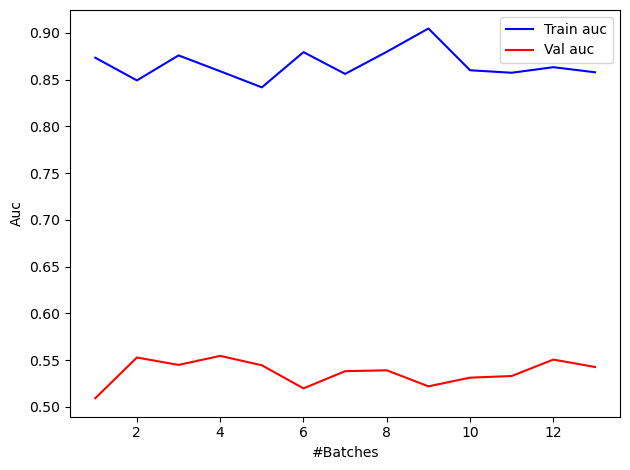

In [ ]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.show()

### Find best parameters

In [ ]:
best_coef = []
best = 0
stream = get_stream(path='./datasets/train.csv', size=batch_size)
idx = 0
X_valid, y_valid = None, None
batch_X, batch_y = None, None
for z in range(iters):
    batch = next(stream)
    batch = next(stream)
    if(idx==0):
        X_valid= batch['Page content']
        y_valid = batch['Popularity']
        idx+=1
    else:
        X_valid = np.concatenate((X_valid, batch['Page content']))
        y_valid = np.concatenate((y_valid, batch['Popularity']))
        
x_valid_title, x_valid_author, x_valid_channel, x_valid_topic, x_valid_weekend, x_valid_media, x_valid_appealing, x_valid_word = combine(X_valid)

In [ ]:
for i in np.linspace(0,1,5):
    for j in np.linspace(0,1-i,5):
        for k in np.linspace(0,1-i-j,5):
            # for h in np.linspace(0,1-i-j-k,5):
            #     for g in np.linspace(0,1-i-j-k-h,5):
            #         for m in np.linspace(0,1-i-j-k-h-g,5):
            n=1-i-j-k
            valid_score = roc_auc_score(y_valid, (clf1.predict_proba(x_valid_title)[:,1]*i+clf2.predict_proba(x_valid_author)[:,1]*j
                                        +clf4.predict_proba(x_valid_topic)[:,1]*k
                                        +clf5.predict_proba(x_valid_weekend)[:,1]*n))
            # valid_score = roc_auc_score(y_valid, (clf1.predict_proba(x_valid_title)[:,1]*i+clf2.predict_proba(x_valid_author)[:,1]*j
            #                             +clf4.predict_proba(x_valid_topic)[:,1]*k
            #                             +clf5.predict_proba(x_valid_weekend)[:,1]*h+clf6.predict_proba(x_valid_media)[:,1]*g
            #                             +clf7.predict_proba(x_valid_appealing)[:,1]*m+clf8.predict_proba(x_valid_word)[:,1]*n))
            if valid_score>best:
                best = valid_score
                best_coef = [i,j,k,n]
                print(f'Valid score: {valid_score}, i: {i}, j: {j}, k:{k}, n: {n}')
print(f'best: {best}, coef: {best_coef}')

Valid score: 0.5291750938676167, i: 0.0, j: 0.0, k:0.0, n: 1.0
Valid score: 0.5385980479148181, i: 0.0, j: 0.0, k:0.25, n: 0.75


KeyboardInterrupt: 

### Prediction

In [ ]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [ ]:
x_test_title, x_test_author, x_test_channel, x_test_topic, x_test_weekend, x_test_media, x_test_appealing, x_test_word = combine(X_test)
y_pred = np.around((clf1.predict_proba(x_test_title)[:,1]*best_coef[0]+clf2.predict_proba(x_test_author)[:,1]*best_coef[1]
                                        +clf4.predict_proba(x_test_topic)[:,1]*best_coef[2]+clf5.predict_proba(x_test_weekend)[:,1]*best_coef[3]
                                        ), decimals=1)

In [ ]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643         0.5
1      27644         0.5
2      27645         0.5
3      27646         0.5
4      27647         0.5
...      ...         ...
11842  39485         0.5
11843  39486         0.5
11844  39487         0.5
11845  39488         0.5
11846  39489         0.5

[11847 rows x 2 columns]
